In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


In [2]:
DATASET_PATH = r"D:\\human+activity+recognition+using+smartphones\\UCI HAR Dataset\\UCI HAR Dataset"


In [6]:
# ===============================
# LOAD UCI HAR DATASET
# ===============================

# Load feature names
features = pd.read_csv(
    f"{DATASET_PATH}/features.txt",
    sep=r"\s+",
    header=None,
    names=["index", "feature"]
)

feature_names = features["feature"].values


# Load activity labels
activity_labels = pd.read_csv(
    f"{DATASET_PATH}/activity_labels.txt",
    sep=r"\s+",
    header=None,
    names=["id", "activity"]
)

activity_map = dict(zip(activity_labels.id, activity_labels.activity))


# Load training data
X_train = pd.read_csv(
    f"{DATASET_PATH}/train/X_train.txt",
    sep=r"\s+",
    header=None
)

y_train = pd.read_csv(
    f"{DATASET_PATH}/train/y_train.txt",
    header=None
)


# Load test data
X_test = pd.read_csv(
    f"{DATASET_PATH}/test/X_test.txt",
    sep=r"\s+",
    header=None
)

y_test = pd.read_csv(
    f"{DATASET_PATH}/test/y_test.txt",
    header=None
)


# Assign column names
X_train.columns = feature_names
X_test.columns = feature_names


# Map numeric activity IDs to activity names
y_train = y_train[0].map(activity_map)
y_test = y_test[0].map(activity_map)


print("✅ Dataset Loaded Successfully")
print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


✅ Dataset Loaded Successfully
Training samples: (7352, 561)
Testing samples: (2947, 561)


In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM Linear": SVC(kernel="linear"),
    "SVM RBF": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



🔹 Training Logistic Regression
Accuracy: 0.9545
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.97      0.88      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.94      0.96       420
  WALKING_UPSTAIRS       0.95      0.94      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947


🔹 Training SVM Linear
Accuracy: 0.9606
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING

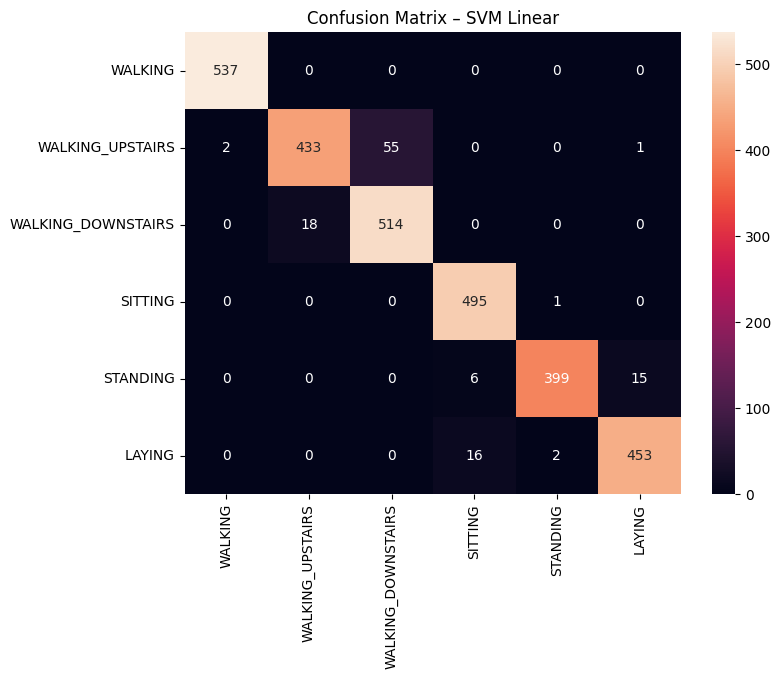

In [9]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=activity_map.values(),
            yticklabels=activity_map.values())
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()


In [10]:
# Combine train + test for clustering
X_all = np.vstack((X_train_scaled, X_test_scaled))
y_all = np.concatenate((y_train, y_test))

# K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_all)

print("K-Means ARI:", adjusted_rand_score(y_all, kmeans_labels))
print("K-Means NMI:", normalized_mutual_info_score(y_all, kmeans_labels))
print("K-Means Silhouette:", silhouette_score(X_all, kmeans_labels))

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(X_all)

print("Agglomerative ARI:", adjusted_rand_score(y_all, agglo_labels))
print("Agglomerative NMI:", normalized_mutual_info_score(y_all, agglo_labels))


K-Means ARI: 0.2915828706589001
K-Means NMI: 0.45686002012025917
K-Means Silhouette: 0.10083570158378863
Agglomerative ARI: 0.47051814159647065
Agglomerative NMI: 0.5947664205909429


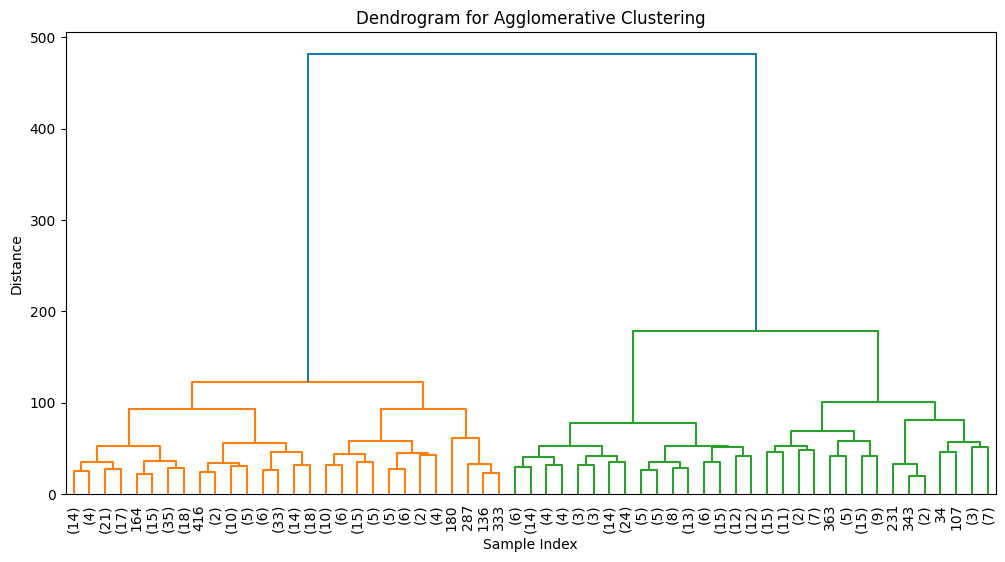

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Take a subset for dendrogram visualization
np.random.seed(42)
subset_size = 500
indices = np.random.choice(X_all.shape[0], subset_size, replace=False)
X_subset = X_all[indices]

# Compute linkage matrix
Z = linkage(X_subset, method='ward')

# Plot dendrogram
plt.figure(figsize=(12,6))
dendrogram(
    Z,
    truncate_mode='level',
    p=5,
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()



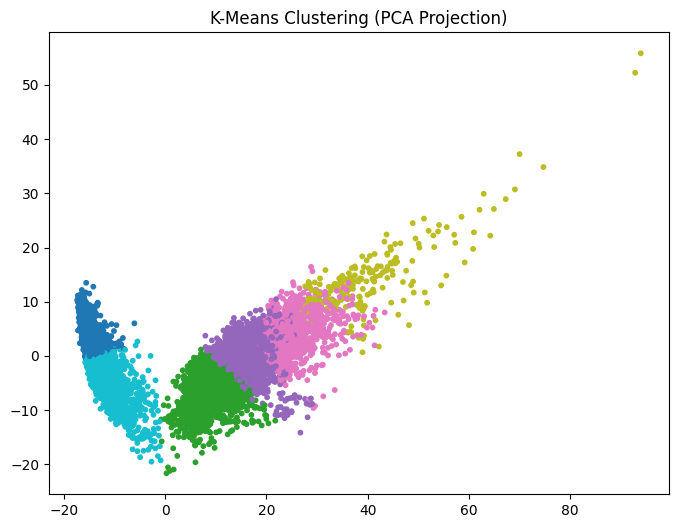

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap="tab10", s=10)
plt.title("K-Means Clustering (PCA Projection)")
plt.show()


In [12]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001]
}

grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best SVM Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best SVM Parameters: {'C': 10, 'gamma': 0.001}
Best CV Score: 0.9355337893145022


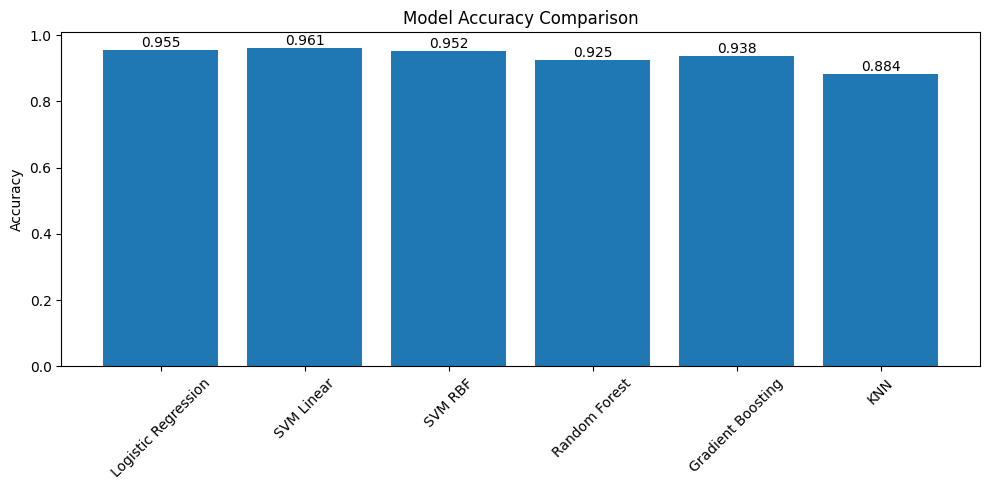

In [ ]:
plt.figure(figsize=(10,5))

bars = plt.bar(results.keys(), results.values())

plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()
